# Power Study

Access the System Model that is in GitHUB folder with a python module "caplellambse" that can read and modify the SMW/Capella model content.

In [1]:
import capellambse
import ipywidgets as widgets
from IPython.core.display import HTML

resources = {
    "Trail_Power_for_Campgrounds": "Trail_Power_for_Campgrounds/Trail Power for Campgrounds",
}
path_to_model = "../Trail Power.aird"
model = capellambse.MelodyModel(path_to_model, resources=resources)

Display a diagram from the capella module with parameters being accessed.


In [2]:
#from IPython import display as diag_display
#diag_display.Image("../Images/Demo 1[LAB] Double Limb AC View.jpg")


Use the slider below to adjust the default values by the slider amount.

In [3]:

#lung_slider = widgets.FloatSlider(min=-3.2, max=5, step=0.1, value=0.0, description='Lung Volume:')
#Inlet_Pressure_slider = widgets.FloatSlider(min=-6, max=6.0, step=0.1, value=0.0, description='Inlet Pressure:')
#Inlet_Temp_slider = widgets.FloatSlider(min=-3.2, max=5, step=0.1, value=0.0, description='Inlet Temp:')
#Shaft_Speed_slider = widgets.FloatSlider(min=-1500, max=3000, step=100, value=0.0, description='Shaft Speed:')
#Ventilator_Rate_slider = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0.0, description='Ventilator Rate:')
#Inhale_Exhale_Duty_Cycle_slider = widgets.FloatSlider(min=-0.6, max=.9, step=0.1, value=0.0, description='Inhale Exhale DutyCycle:')
#display(lung_slider,Inlet_Pressure_slider,Inlet_Temp_slider,Shaft_Speed_slider,Ventilator_Rate_slider,Inhale_Exhale_Duty_Cycle_slider )

# Display all the parameters and respective components
Python is used to access the System Model parameters overwrite the default AMESIM parameters in the System, Controller and Ventilator.

In [4]:
la_model = model.la 

for function in la_model.all_functions:
    for pvg in  function.applied_property_value_groups :
        for pv in  pvg.property_values:
            print("LogicalFunction=",'"' +function.name+ '"',"property_value_groups=",'"' +pvg.name+ '"','"Property Name"=','"' +pv.name+ '"','"Value"=',pv.value )

for component in la_model.all_components:
    for pvg in  component.applied_property_value_groups :
        for pv in  pvg.property_values:
            print("LogicalComponents=",'"' +component.name+ '"',"property_value_groups=",'"' +pvg.name+ '"','Property Name=','"' + pv.name + '"','Value=',pv.value  )

  

LogicalFunction= "Accept Charger" property_value_groups= "DailyActivity" "Property Name"= "Units" "Value"= Percent
LogicalFunction= "Accept Charger" property_value_groups= "DailyActivity" "Property Name"= "Value" "Value"= 0.15
LogicalComponents= "Boost" property_value_groups= "Boost Efficiency" Property Name= "Units" Value= Percent
LogicalComponents= "Boost" property_value_groups= "Boost Efficiency" Property Name= "Value" Value= 90.0
LogicalComponents= "Boost" property_value_groups= "DeviceCurrentLimit" Property Name= "Units" Value= A
LogicalComponents= "Boost" property_value_groups= "DeviceCurrentLimit" Property Name= "Value" Value= 2.0
LogicalComponents= "Battery" property_value_groups= "Battery Capacity" Property Name= "Units" Value= mAh
LogicalComponents= "Battery" property_value_groups= "Battery Capacity" Property Name= "Value" Value= 2800.0
LogicalComponents= "Solar Panel" property_value_groups= "Solar Panel Wattage" Property Name= "Units" Value= Watts
LogicalComponents= "Solar P

The code to retrive a value would be the following. 

your_variable = model.search("LogicalFunction").by_name("Name of Function").property_value_groups["Name of property Value Group"]["Name of Property"])

In [5]:
print( model.search("LogicalFunction").by_name("Accept Charger").property_value_groups["DailyActivity"]["Value"])

0.15


$$Daily Sun Light = Square_Wave(t,Daily_Sunlight_in_Percent)$$


In [6]:
from sympy import symbols, Piecewise, sin, pi, Heaviside, integrate
import numpy as np
import matplotlib.pyplot as plt


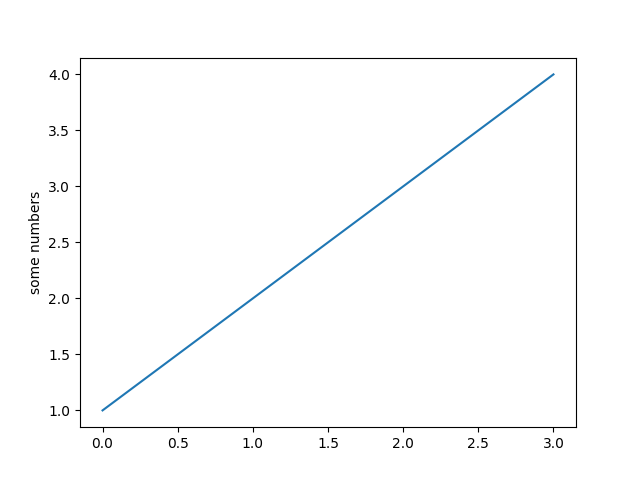

In [7]:

plt.plot([1, 2, 3, 4])
plt.ylabel('some numbers')
plt.show()

In [8]:
t = symbols('t')
period = symbols('period')


In [9]:
def power_generator(t, period, SP_Power ):
    return SP_Power * Piecewise(
        (1, (t % period) < period / 2),
        (0, (t % period) >= period / 2)
    )


In [10]:
period_value = model.search("LogicalComponent").by_name("Sun").property_value_groups["DailySunLight"]["Value"] * 24/100  # Example period of 12 hours for .50
panel_power = model.search("LogicalComponent").by_name("Solar Panel").property_value_groups["Solar Panel Wattage"]["Value"]
charger_eff =model.search("LogicalComponent").by_name("Charger").property_value_groups["Charger Efficiency"]["Value"]

print(period_value)
print(panel_power)


12.0
20.0


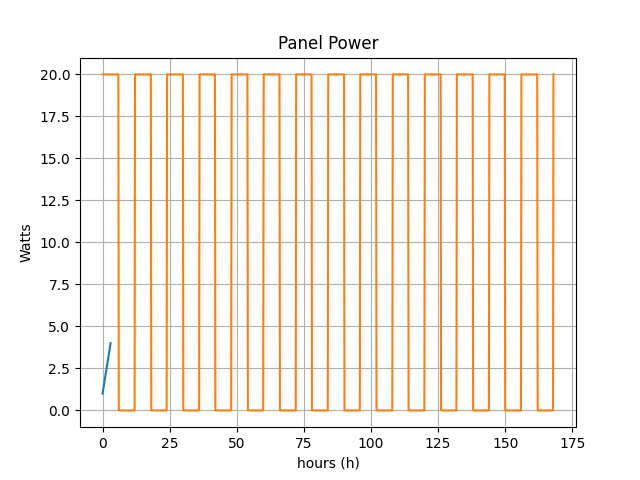

In [11]:
power_expr = power_generator(t, period_value, panel_power ) 

# Substitute period value into the expression
power_func = power_expr.subs(period, period_value)

# Generate data for plotting
t_vals = np.linspace(0, 7*24, 1000)
panel_powers = [power_func.evalf(subs={t: val}) for val in t_vals]

# Plot the square wave
plt.plot(t_vals,panel_powers  )
plt.xlabel('hours (h)')
plt.ylabel('Watts')
plt.title('Panel Power')
plt.grid(True)
plt.show()

In [12]:
def battery_charge(t, period, SP_Power ):
    return SP_Power * Piecewise(
        (1, (t % period) < period / 2),
        (0, (t % period) >= period / 2)
    )


In [ ]:

# Time range for the analysis
t_vals = np.linspace(0, 10, 1000)  # from 0 to 10 seconds
energy_accumulated = []

battery_charge_expr = battery_charge(t, period_value, panel_power ) 
power_expr = power_generator(t, period_value, panel_power ) 

# Compute the cumulative energy over time
for t_end in t_vals:
    energy = integrate(battery_charge_expr , (t, 0, t_end)).subs(period, period_value )
    energy_accumulated.append(energy)

# Plot the cumulative energy as a function of time
plt.plot(t_vals, energy_accumulated, label='Cumulative Energy in Battery')
plt.xlabel('Time (s)')
plt.ylabel('Cumulative Energy (Joules)')
plt.title('Cumulative Energy Over Time')
plt.grid(True)
plt.legend()
plt.show()